In [2]:
import gpytorch
import matplotlib.pyplot as plt
import torch
from func_data_generation import *
from func_polygon import *
from torch import nn
from utils import *
from warp_units import *

# from torchsummary import summary


dtype = torch.double
device = "cuda" if torch.cuda.is_available() else "cpu"
# device =  "cpu"
print("Using {} device".format(device))

import tqdm

torch.set_default_dtype(dtype)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

Using cuda device


# Define Modle

In [3]:
class QuodralMean(gpytorch.means.Mean):
    def __init__(self):
        super().__init__()
        self.register_parameter(
            name="weights",
            parameter=torch.nn.Parameter(torch.randn(5, 1)),
        )
        self.register_parameter(
            name="bias", parameter=torch.nn.Parameter(torch.randn(1))
        )

    def forward(self, x):
        xx = torch.stack(
            (
                x[:, 0] * x[:, 0],
                x[:, 0] * x[:, 1],
                x[:, 1] * x[:, 1],
                x[:, 0],
                x[:, 1],
            ),
            dim=1,
        )
        res = xx.matmul(self.weights).squeeze(-1)
        return res + self.bias


class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        #         self.mean_module = QuodralMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Load Data

In [4]:
data_num = 1
sensor_num = 200  # [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# load data
coords, shadow, shadow_noise, train_X, train_y, idx = load_data(data_num, sensor_num)

In [5]:
# Normalize train_X to 0-1
train_X_tensor = torch.from_numpy(train_X).to(device) / 1000
coords_tensor = torch.from_numpy(coords).to(device) / 1000

train_y_tensor = torch.from_numpy(train_y).to(device)
# train_y_mean = train_y_tensor.mean()
# train_y_tensor = train_y_tensor - train_y_mean
# train_y_sigma = torch.sqrt(train_y_tensor.var())
# train_y_tensor = (train_y_tensor - train_y_mean) / train_y_sigma

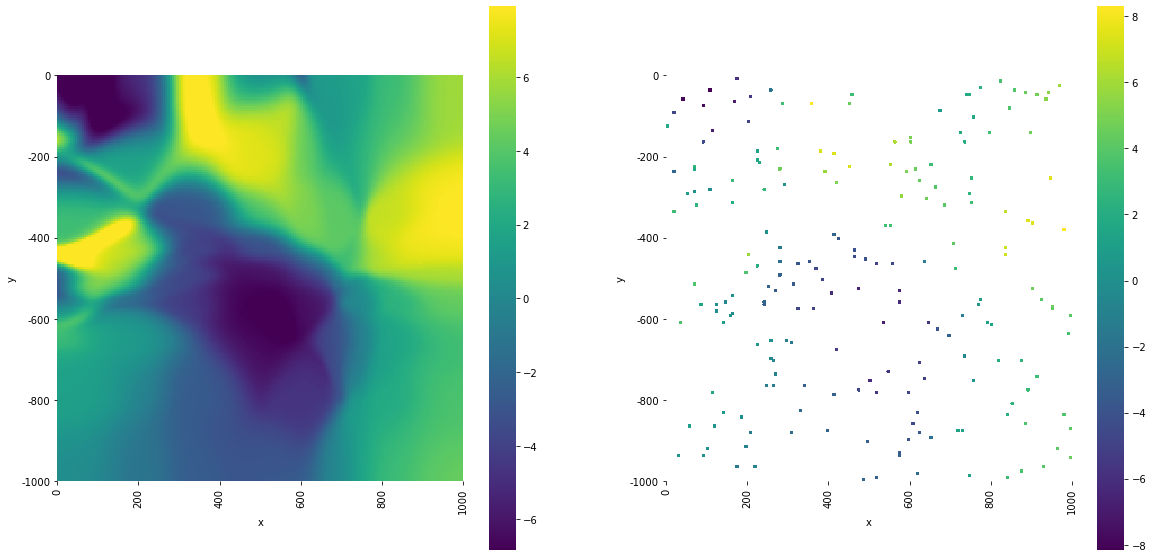

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_heatmap(coords, shadow, ax=axes[0], robust=True, cbar=True)
plot_heatmap(
    coords,
    shadow_noise,
    mask_idx=idx,
    ax=axes[1],
    cbar=True,
)

# Initialize Model

In [7]:
# initialize likelihood and model

likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(train_X_tensor, train_y_tensor, likelihood).to(device)
model.likelihood.noise = 0.2
# model.covar_module.base_kernel.lengthscale = 0.087
# model.covar_module.outputscale = 12.617
# model.covar_module.base_kernel.lengthscale = 1
# model.covar_module.outputscale = 50

In [8]:
# for name, param in model.named_parameters():
#     print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")

In [9]:
# Use the adam optimizer
optimizer = torch.optim.Adam(
    [
        {"params": model.covar_module.parameters()},
        {"params": model.mean_module.parameters()},
        #         {"params": model.likelihood.parameters()},
    ],
    lr=0.01,
)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


def train():
    iterator = tqdm.notebook.tqdm(range(training_iterations))
    for i, j in enumerate(iterator):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_X_tensor)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y_tensor)
        loss.backward()
        #         iterator.set_postfix(
        #             loss=loss.item(),
        #             #             output_scale=model.covar_module.outputscale.item(),
        #             #             big_output_scale=model.covar_module.kernels[1].outputscale.item(),
        #             #             big_lengthscale=model.covar_module.kernels[
        #             #                 1
        #             #             ].base_kernel.lengthscale.item(),
        #             #             leng_scale=model.covar_module.kernels.base_kernel.lengthscale.item(),
        #             noise=model.likelihood.noise.item(),
        #         )
        if i % 10 == 9:
            writer.add_scalar("loss", loss.item(), i)
            writer.add_scalar(
                "length_scale", model.covar_module.base_kernel.lengthscale.item(), i
            )
            writer.add_scalar("output_scale", model.covar_module.outputscale.item(), i)
        #             writer.add_scalar("noise", model.likelihood.noise.item(), i)

        optimizer.step()

In [10]:
# Define tensorboard writer
now = datetime.now()
log_dir = "logs/gp/" + now.strftime("%Y%m%d-%H%M%S") + "/"
writer = SummaryWriter(log_dir)

# Set to train state
model.train()
likelihood.train()

# Train
training_iterations = 30000
%time train()

  0%|          | 0/30000 [00:00<?, ?it/s]

CPU times: user 2h 37min 19s, sys: 2min 4s, total: 2h 39min 24s
Wall time: 5min 35s


In [11]:
sigma = model.covar_module.outputscale.item()
l = model.covar_module.base_kernel.lengthscale.item()
print("sigma=%.3f" % model.covar_module.outputscale.item())
print("l=%.3f" % model.covar_module.base_kernel.lengthscale.item())

sigma=12.617
l=0.087


In [12]:
likelihood.eval()
model.eval()
observed_pred = model(coords_tensor)
mean = observed_pred.mean.detach()
var = observed_pred.variance.detach()

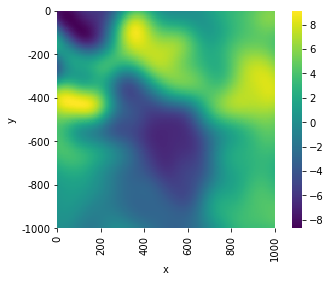

In [13]:
fig, ax = plt.subplots()
plot_heatmap(
    coords,
    mean,
    ax=ax,
    cbar=True,
    #     vmin=-103,
    #     vmax=-63,
)

In [25]:
save_result("result_1", "gp", sensor_num, mean.cpu().numpy(), var.cpu().numpy())

In [14]:
def train():
    iterator = tqdm.notebook.tqdm(range(training_iterations))
    for i, j in enumerate(iterator):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_X_tensor)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y_tensor)
        loss.backward()
        #         iterator.set_postfix(
        #             loss=loss.item(),
        #             #             output_scale=model.covar_module.outputscale.item(),
        #             #             big_output_scale=model.covar_module.kernels[1].outputscale.item(),
        #             #             big_lengthscale=model.covar_module.kernels[
        #             #                 1
        #             #             ].base_kernel.lengthscale.item(),
        #             #             leng_scale=model.covar_module.kernels.base_kernel.lengthscale.item(),
        #             noise=model.likelihood.noise.item(),
        #         )
        if i % 10 == 9:
            writer.add_scalar("loss", loss.item(), i)
            writer.add_scalar(
                "length_scale", model.covar_module.base_kernel.lengthscale.item(), i
            )
            writer.add_scalar("output_scale", model.covar_module.outputscale.item(), i)
        #             writer.add_scalar("noise", model.likelihood.noise.item(), i)

        optimizer.step()

In [15]:
data_num = 1
result_file_name = "/result_" + str(data_num)

for sensor_num in range(250, 801, 50):
    coords, shadow, shadow_noise, train_X, train_y, idx = load_data(
        data_num, sensor_num
    )

    # Normalize train_X to 0-1
    train_X_tensor = torch.from_numpy(train_X).to(device) / 1000
    coords_tensor = torch.from_numpy(coords).to(device) / 1000

    train_y_tensor = torch.from_numpy(train_y).to(device)
    # initialize likelihood and model

    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactGPModel(train_X_tensor, train_y_tensor, likelihood).to(device)
    model.likelihood.noise = 0.2
    model.covar_module.base_kernel.lengthscale = l
    model.covar_module.outputscale = sigma

    optimizer = torch.optim.Adam(
        [
            {"params": model.covar_module.parameters()},
            {"params": model.mean_module.parameters()},
            {"params": model.likelihood.parameters()},
        ],
        lr=0.01,
    )
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Define tensorboard writer
    now = datetime.now()
    log_dir = "logs/gp/" + now.strftime("%Y%m%d-%H%M%S") + "/"
    writer = SummaryWriter(log_dir)

    # Set to train state
    model.train()
    likelihood.train()

    # Train
    training_iterations = 20000
    train()

    likelihood.eval()
    model.eval()
    observed_pred = model(coords_tensor)
    mean = observed_pred.mean.detach()
    var = observed_pred.variance.detach()

    save_result(
        result_file_name, "gp", sensor_num, mean.cpu().numpy(), var.cpu().numpy()
    )

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]